# Chapter 4: Influential Classification Tools - TensorFlow Hub

In this fourth notebook dedicated to Chapter 4, we will this time illustrate how to reuse models provided on TensorFlow Hub. As presented in the book, this platform offers several CNN implementations along with pre-trained weights, shared by experts.

First, we will explain how to build a generic TensorFlow Estimator for classification based on TF Hub modules. Then we will demonstrate its usage by instantiating an Inception network and a ResNet one, once again to classify Tiny-ImageNet samples (c.f. previous notebooks).

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os

In [2]:
from tiny_imagenet import (
    tiny_imagenet, _training_augmentation_fn, tiny_imagenet_input_fn,
    IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, NUM_CLASSES)

TINY_IMAGENET_ROOT_FOLDER = os.path.expanduser('~/datasets/tiny-imagenet-200/')
NUM_TRAINING_IMAGES = 500 * NUM_CLASSES
NUM_VAL_IMAGES = 50 * NUM_CLASSES

batch_size = 32
num_epochs = 30

train_steps_per_epoch = NUM_TRAINING_IMAGES // batch_size
val_steps_per_epoch = NUM_VAL_IMAGES // batch_size

## Estimators based on TF Hub Modules

In Chapter 4, we explained how TF Hub can be called to fetch a pre-defined feature extractor, and how to build a classification model around.

For example, a classification network for Tiny-ImageNet based on the Inception architecture can be created with TF Hub as follow. First, we need to search the TF Hub catalog ([https://tfhub.dev](https://tfhub.dev)) to find a satisfying module, e.g. "[https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1](https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1)" (Inception V3 model pre-trained on ImageNet). Then, we can use the link to the model's page to define and initialize it:

In [11]:
model_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"

original_images = tf.placeholder(
    tf.float32, shape=(None, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))  # replace with actual input pipeline

# Fetching the network from TF Hub:
module_spec = hub.load_module_spec(model_url)
inception_net = hub.Module(module_spec)

# Adapting the inputs to the network's specs:
height, width = hub.get_expected_image_size(module_spec)
images = tf.image.resize_images(original_images, size=tf.convert_to_tensor([height, width]))

# Putting everything together:
features = inception_net(images)
logits = tf.layers.dense(features, NUM_CLASSES)
predictions = tf.nn.softmax(logits)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


This simple code can be expanded and used as the _model function_ to build a TensorFlow Estimator (with all its utilities).

In the next cell, we define a _factory_ method, returning a custom _model function_ based on the provided TF Hub URL. As we just did, the partial function it returns fetches the corresponding TF Hub module and add the proper prediction layers on top. It also defines the model's behavior depending on the requested mode:

 - For the _training_ mode, the function defines the classification loss and the training operations (optimizer step, metrics, etc.);
 - For _evaluation_, only the metrics are computed;
 - For _prediction_, the network's outputs are simply returned.
 
Note that if we want to retrain/fine-tune the module fetched from TF Hub, it has to be specified during the call (`module = hub.Module(module_spec, trainable=True)`, so that TF Hub also returns the proper training hooks for these layers.

All in all, our TF-Hub/Estimator factory can be implemented as follow:

In [3]:
def tf_hub_classifier_factory(model_url, fine_tune=False):
    """
    Return a function to instantiate a particular TF Hub classification model.
    :param model_url:   URL of the TF Hub model
    :param fine_tune:   Flag to fine-tune the whole model
    :return:            Function to instantiate a Tensorflow Estimator model
    """
    
    def model_fn(features, labels, mode):
        
        # Load model from TF Hub:
        module_spec = hub.load_module_spec(model_url)
        # If we want to retrain/fine-tune the module's weights, we need to let TF-Hub know:
        model_tags = {'train'} if fine_tune and mode == tf.estimator.ModeKeys.TRAIN else None
        module = hub.Module(module_spec, trainable=fine_tune, tags=model_tags)
        input_layer = features["image"]
        
        # Adapting the inputs to the network's specs:
        height, width = hub.get_expected_image_size(module_spec)
        input_layer = tf.image.resize_images(input_layer, size=tf.convert_to_tensor([height, width]))
    
        # We assume the TF Hub modules are of the type `feature extractor`, 
        # i.e. they are models without the final prediction layers, only returning
        # meaningful extracted features, which can then be used for classification:
        extracted_features = module(input_layer)
        
        # Therefore, we add ourselves the final layer(s) to infer the classes based on 
        # those features (simple FC layer with softmax here):
        logits = tf.layers.dense(inputs=extracted_features, units=NUM_CLASSES, name="logits_pred")
        probabilities = tf.nn.softmax(logits, name="softmax_pred")
        predictions = tf.argmax(input=probabilities, axis=1, name="predictions")
    
        # Defining the network's outputs:
        predictions_dict = {'predictions': predictions, 'probabilities': probabilities}
        
        # If we are in predict mode (e.g., in production), we are done defining our model:
        if mode == tf.estimator.ModeKeys.PREDICT:
            # In prediction/production mode, we define our Estimator to simply return the
            # predictions outputs (the predicted classes + probabilities):
            return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions_dict)
        
        # Otherwise, we still need to define the losses and metrics for training and validation.
        
        # Defining the training loss and adding it to Tensorboard:
        with tf.name_scope('loss'):
            # Cross-entropy loss on the classification predictions:
            loss = tf.losses.sparse_softmax_cross_entropy(
                labels=labels, logits=logits, scope='loss_classification')
            tf.summary.scalar('loss', loss) # to track this value in Tensorboard

            if fine_tune and mode == tf.estimator.ModeKeys.TRAIN:
                # The TF Hub model may have some regularization losses defined,
                # so we recover and add them to the main loss when fine-tuning:
                loss_reg = tf.losses.get_regularization_loss()
                tf.summary.scalar('loss_reg', loss_reg) # to track this value in Tensorboard
                loss = tf.add(loss, loss_reg, name="loss_total")

        # Similarly, defining the accuracy metrics:
        with tf.name_scope('metrics'):
            # Classic accuracy (i.e. top-1):
            accuracy = tf.metrics.accuracy(
                labels=labels, predictions=predictions, name='accuracy')
            tf.summary.scalar('accuracy', accuracy[1]) # to track this value in Tensorboard

            # Top-5 accuracy, implemented with TF methods (see Chapter 4 and previous notebooks for details):
            top5_accuracy = tf.metrics.mean(tf.nn.in_top_k(
                predictions=probabilities, targets=labels, k=5), name='top5_accuracy')
            tf.summary.scalar('top5_accuracy', top5_accuracy[1]) # to track this value in Tensorboard
    
        if mode == tf.estimator.ModeKeys.TRAIN:
            # In train mode, we specify the training operations:
            with tf.name_scope('train'):
                optimizer = tf.train.MomentumOptimizer(
                    learning_rate=0.001, momentum=0.9, use_nesterov=True)
                train_op = optimizer.minimize(
                    loss=loss, global_step=tf.train.get_global_step())
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
        else:   # EVAL mode
            # In evaluation mode, we specify the metrics we want displayed:
            with tf.name_scope('eval'):
                eval_metric_ops = {'accuracy': accuracy,  'top5_accuracy': top5_accuracy}
                return tf.estimator.EstimatorSpec(
                    mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)
            
    return model_fn


Given a `model_url` from TF Hub, we can therefore instantiate a classification Estimator based on it in a single-line now, e.g.:

In [ ]:
estimator = tf.estimator.Estimator(model_fn=tf_hub_classifier_factory(model_url, fine_tune=False))

## Usage of TF Hub Estimators 

Like in previous notebooks for this Chapter 4, we will apply our models to the task of classifying Tiny-ImageNet samples. To illustrate the versatility of our Estimator _factory_, we will train both an Inception network and a ResNet one.

The following examples will be also the opportunity to demonstrate the performance of classifiers based on feature extractors pre-trained on rich datasets (check Chapter 4 for explanations). We will only train the dense layers on top of the TF Hub networks, freezing the underlying layers (using `tf_hub_classifier_factory(..., fine_tune=False)`).

Note that again, like in previous notebooks, we set up our input pipelines calling the methods we implemented in the first [notebook](./ch4_notebook_1_data_preparation.ipynb) for this chapter.

### Training an Inception Classifier

In the following cell, we instantiate a classification Estimator based on a Inception feature extractor pre-trained on ImageNet, set up the data pipelines and training specifications, before launching the process:

In [5]:
model_url = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"
model_dir = './models/inception_tf_hub'

with tf.Graph().as_default() as graph:
    
    # Instantiating our ResNet Estimator from TF Hub:
    inception_model_fn = tf_hub_classifier_factory(model_url, fine_tune=False)
    
    inception_model = tf.estimator.Estimator(
        model_fn=inception_model_fn, model_dir=model_dir)
    
    # Setting up the input pipelines, training hooks, specs, etc.:
    training_input_fn = tiny_imagenet_input_fn(
        phase='train', shuffle=True, batch_size=batch_size, num_epochs=num_epochs,
        augmentation_fn=_training_augmentation_fn, 
        root_folder=TINY_IMAGENET_ROOT_FOLDER)
    
    validation_input_fn = tiny_imagenet_input_fn(
        phase='val', shuffle=False, batch_size=batch_size, num_epochs=1,
        augmentation_fn=None, root_folder=TINY_IMAGENET_ROOT_FOLDER)
    
    # Adding a logging hook, to have TF shows some metrics in the training logs:
    logging_hook = tf.train.LoggingTensorHook(
        tensors={
            # We can select the tensors to display using the names we gave them:
            'acc': 'metrics/accuracy/value', 'top5-acc': 'metrics/top5_accuracy/value'
        }, every_n_iter=1000)
    
    train_spec = tf.estimator.TrainSpec(
        input_fn=training_input_fn,
        max_steps=train_steps_per_epoch * num_epochs,
        hooks=[logging_hook])

    eval_spec = tf.estimator.EvalSpec(
        input_fn=validation_input_fn,
        steps=val_steps_per_epoch * 1,
        start_delay_secs=300, # evaluating after waiting for this many seconds.
        throttle_secs=200)  # waiting at least this many seconds between 2 evaluations.
    
    # Training:
    tf.estimator.train_and_evaluate(inception_model, train_spec, eval_spec)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './models/inception_tf_hub', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3c2afbedd8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:te

INFO:tensorflow:loss = 1.274571, step = 6200 (9.270 sec)
INFO:tensorflow:Saving checkpoints for 6262 into ./models/inception_tf_hub/model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-14-07:18:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/inception_tf_hub/model.ckpt-6262
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [31/312]
INFO:tensorflow:Evaluation [62/312]
INFO:tensorflow:Evaluation [93/312]
INFO:tensorflow:Evaluation [124/312]
INFO:tensorflow:Evaluation [155/312]
INFO:tensorflow:Evaluation [186/312]
INFO:tensorflow:Evaluation [217/312]
INFO:tensorflow:Evaluation [248/312]
INFO:tensorflow:Evaluation [279/312]
INFO:tensorflow:Evaluation [310/312]
INFO:tensorflow:Evaluation [312/312]
INFO:tensorflow:Finished ev

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [31/312]
INFO:tensorflow:Evaluation [62/312]
INFO:tensorflow:Evaluation [93/312]
INFO:tensorflow:Evaluation [124/312]
INFO:tensorflow:Evaluation [155/312]
INFO:tensorflow:Evaluation [186/312]
INFO:tensorflow:Evaluation [217/312]
INFO:tensorflow:Evaluation [248/312]
INFO:tensorflow:Evaluation [279/312]
INFO:tensorflow:Evaluation [310/312]
INFO:tensorflow:Evaluation [312/312]
INFO:tensorflow:Finished evaluation at 2019-01-14-07:28:37
INFO:tensorflow:Saving dict for global step 12363: accuracy = 0.4223758, global_step = 12363, loss = 2.6561399, top5_accuracy = 0.6910056
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12363: ./models/inception_tf_hub/model.ckpt-12363
INFO:tensorflow:global_step/sec: 2.26975
INFO:tensorflow:loss = 0.9155587, step = 12400 (44.058 sec)
INFO:tensorflow:global_step/sec: 10.6601
INFO:tensorflow:loss = 4.2299013, step = 12500 (9.381 sec)


INFO:tensorflow:Evaluation [312/312]
INFO:tensorflow:Finished evaluation at 2019-01-14-07:38:36
INFO:tensorflow:Saving dict for global step 18446: accuracy = 0.46534455, global_step = 18446, loss = 2.5079558, top5_accuracy = 0.7275641
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18446: ./models/inception_tf_hub/model.ckpt-18446
INFO:tensorflow:global_step/sec: 2.29162
INFO:tensorflow:loss = 0.7321837, step = 18500 (43.637 sec)
INFO:tensorflow:global_step/sec: 10.7569
INFO:tensorflow:loss = 1.5370045, step = 18600 (9.296 sec)
INFO:tensorflow:global_step/sec: 10.7249
INFO:tensorflow:loss = 0.75560534, step = 18700 (9.324 sec)
INFO:tensorflow:global_step/sec: 10.6959
INFO:tensorflow:loss = 0.6352803, step = 18800 (9.349 sec)
INFO:tensorflow:global_step/sec: 10.6551
INFO:tensorflow:loss = 0.31748778, step = 18900 (9.389 sec)
INFO:tensorflow:global_step/sec: 10.8401
INFO:tensorflow:acc = 0.759375, top5-acc = 0.8865132 (127.311 sec)
INFO:tensorflow:loss = 0.5477993, step 

INFO:tensorflow:global_step/sec: 10.7452
INFO:tensorflow:loss = 0.44372267, step = 24700 (9.306 sec)
INFO:tensorflow:global_step/sec: 10.8821
INFO:tensorflow:loss = 0.7783791, step = 24800 (9.188 sec)
INFO:tensorflow:global_step/sec: 10.882
INFO:tensorflow:loss = 0.6470802, step = 24900 (9.190 sec)
INFO:tensorflow:global_step/sec: 10.9941
INFO:tensorflow:acc = 0.778375, top5-acc = 0.900625 (127.423 sec)
INFO:tensorflow:loss = 3.968619, step = 25000 (9.096 sec)
INFO:tensorflow:global_step/sec: 10.8989
INFO:tensorflow:loss = 0.31733945, step = 25100 (9.174 sec)
INFO:tensorflow:global_step/sec: 10.7883
INFO:tensorflow:loss = 0.6458136, step = 25200 (9.269 sec)
INFO:tensorflow:global_step/sec: 10.7512
INFO:tensorflow:loss = 0.21695334, step = 25300 (9.301 sec)
INFO:tensorflow:global_step/sec: 10.7244
INFO:tensorflow:loss = 0.44646263, step = 25400 (9.325 sec)
INFO:tensorflow:global_step/sec: 10.7373
INFO:tensorflow:loss = 0.5578306, step = 25500 (9.313 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 10.5859
INFO:tensorflow:loss = 1.232774, step = 31200 (9.446 sec)
INFO:tensorflow:global_step/sec: 10.8332
INFO:tensorflow:loss = 0.78403044, step = 31300 (9.231 sec)
INFO:tensorflow:global_step/sec: 10.853
INFO:tensorflow:loss = 0.626446, step = 31400 (9.214 sec)
INFO:tensorflow:global_step/sec: 10.6697
INFO:tensorflow:loss = 0.4930219, step = 31500 (9.372 sec)
INFO:tensorflow:global_step/sec: 10.8646
INFO:tensorflow:loss = 0.6585249, step = 31600 (9.204 sec)
INFO:tensorflow:global_step/sec: 10.5229
INFO:tensorflow:loss = 0.9268338, step = 31700 (9.504 sec)
INFO:tensorflow:global_step/sec: 10.3877
INFO:tensorflow:loss = 1.10467, step = 31800 (9.627 sec)
INFO:tensorflow:global_step/sec: 10.6885
INFO:tensorflow:loss = 0.54699117, step = 31900 (9.354 sec)
INFO:tensorflow:global_step/sec: 10.724
INFO:tensorflow:acc = 0.7908203, top5-acc = 0.9109375 (93.646 sec)
INFO:tensorflow:loss = 0.55197304, step = 32000 (9.327 sec)
INFO:tensorflow:global_step/sec: 10.

INFO:tensorflow:loss = 0.12486291, step = 37700 (9.258 sec)
INFO:tensorflow:global_step/sec: 10.8822
INFO:tensorflow:loss = 0.84288555, step = 37800 (9.189 sec)
INFO:tensorflow:global_step/sec: 10.7074
INFO:tensorflow:loss = 0.42811155, step = 37900 (9.340 sec)
INFO:tensorflow:global_step/sec: 10.8799
INFO:tensorflow:acc = 0.79851973, top5-acc = 0.9165296 (92.619 sec)
INFO:tensorflow:loss = 0.49853277, step = 38000 (9.193 sec)
INFO:tensorflow:global_step/sec: 10.7387
INFO:tensorflow:loss = 0.53200096, step = 38100 (9.310 sec)
INFO:tensorflow:global_step/sec: 10.7734
INFO:tensorflow:loss = 1.2331779, step = 38200 (9.282 sec)
INFO:tensorflow:global_step/sec: 10.7944
INFO:tensorflow:loss = 0.687626, step = 38300 (9.264 sec)
INFO:tensorflow:global_step/sec: 10.6504
INFO:tensorflow:loss = 0.8750099, step = 38400 (9.389 sec)
INFO:tensorflow:global_step/sec: 10.7589
INFO:tensorflow:loss = 1.0412474, step = 38500 (9.296 sec)
INFO:tensorflow:global_step/sec: 10.7258
INFO:tensorflow:loss = 0.931

INFO:tensorflow:global_step/sec: 10.8631
INFO:tensorflow:loss = 1.356712, step = 44200 (9.206 sec)
INFO:tensorflow:global_step/sec: 10.8123
INFO:tensorflow:loss = 0.7759874, step = 44300 (9.248 sec)
INFO:tensorflow:global_step/sec: 10.6487
INFO:tensorflow:loss = 1.1413984, step = 44400 (9.391 sec)
INFO:tensorflow:global_step/sec: 10.6707
INFO:tensorflow:loss = 0.7330917, step = 44500 (9.372 sec)
INFO:tensorflow:global_step/sec: 10.5977
INFO:tensorflow:loss = 1.2039545, step = 44600 (9.436 sec)
INFO:tensorflow:global_step/sec: 10.9015
INFO:tensorflow:loss = 0.4738626, step = 44700 (9.173 sec)
INFO:tensorflow:global_step/sec: 10.8491
INFO:tensorflow:loss = 0.5525985, step = 44800 (9.217 sec)
INFO:tensorflow:global_step/sec: 10.8197
INFO:tensorflow:loss = 0.10693684, step = 44900 (9.245 sec)
INFO:tensorflow:global_step/sec: 10.772
INFO:tensorflow:acc = 0.8042361, top5-acc = 0.92041665 (92.848 sec)
INFO:tensorflow:loss = 0.56474674, step = 45000 (9.281 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:global_step/sec: 10.6149
INFO:tensorflow:loss = 0.7626401, step = 50800 (9.421 sec)
INFO:tensorflow:global_step/sec: 10.8808
INFO:tensorflow:loss = 1.0329727, step = 50900 (9.190 sec)
INFO:tensorflow:global_step/sec: 10.7414
INFO:tensorflow:acc = 0.8086397, top5-acc = 0.9230392 (92.902 sec)
INFO:tensorflow:loss = 0.38835472, step = 51000 (9.312 sec)
INFO:tensorflow:global_step/sec: 10.7049
INFO:tensorflow:loss = 0.7047756, step = 51100 (9.341 sec)
INFO:tensorflow:global_step/sec: 10.7809
INFO:tensorflow:loss = 0.37527135, step = 51200 (9.274 sec)
INFO:tensorflow:global_step/sec: 10.8085
INFO:tensorflow:loss = 0.47233176, step = 51300 (9.252 sec)
INFO:tensorflow:global_step/sec: 10.8745
INFO:tensorflow:loss = 0.4508288, step = 51400 (9.196 sec)
INFO:tensorflow:global_step/sec: 10.7937
INFO:tensorflow:loss = 0.41159725, step = 51500 (9.265 sec)
INFO:tensorflow:global_step/sec: 10.8055
INFO:tensorflow:loss = 0.51370025, step = 51600 (9.254 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 10.8049
INFO:tensorflow:loss = 0.81725514, step = 57300 (9.255 sec)
INFO:tensorflow:global_step/sec: 10.762
INFO:tensorflow:loss = 0.4445305, step = 57400 (9.292 sec)
INFO:tensorflow:global_step/sec: 10.8707
INFO:tensorflow:loss = 0.20299457, step = 57500 (9.199 sec)
INFO:tensorflow:global_step/sec: 10.7069
INFO:tensorflow:loss = 0.5405703, step = 57600 (9.339 sec)
INFO:tensorflow:global_step/sec: 10.8206
INFO:tensorflow:loss = 0.3812091, step = 57700 (9.241 sec)
INFO:tensorflow:global_step/sec: 10.8235
INFO:tensorflow:loss = 0.72387886, step = 57800 (9.240 sec)
INFO:tensorflow:global_step/sec: 10.7222
INFO:tensorflow:loss = 0.54165554, step = 57900 (9.326 sec)
INFO:tensorflow:global_step/sec: 10.8259
INFO:tensorflow:acc = 0.8145474, top5-acc = 0.9278556 (92.629 sec)
INFO:tensorflow:loss = 0.4720658, step = 58000 (9.240 sec)
INFO:tensorflow:global_step/sec: 10.8902
INFO:tensorflow:loss = 0.50217, step = 58100 (9.180 sec)
INFO:tensorflow:global_step/sec:

INFO:tensorflow:loss = 0.6360744, step = 63800 (9.271 sec)
INFO:tensorflow:global_step/sec: 10.7626
INFO:tensorflow:loss = 0.46134612, step = 63900 (9.291 sec)
INFO:tensorflow:global_step/sec: 10.6848
INFO:tensorflow:acc = 0.81821287, top5-acc = 0.9300293 (93.027 sec)
INFO:tensorflow:loss = 0.33061647, step = 64000 (9.361 sec)
INFO:tensorflow:global_step/sec: 10.681
INFO:tensorflow:loss = 1.0038357, step = 64100 (9.360 sec)
INFO:tensorflow:global_step/sec: 10.8244
INFO:tensorflow:loss = 0.15649481, step = 64200 (9.239 sec)
INFO:tensorflow:global_step/sec: 10.9024
INFO:tensorflow:loss = 0.67082405, step = 64300 (9.172 sec)
INFO:tensorflow:global_step/sec: 10.9932
INFO:tensorflow:loss = 0.8097037, step = 64400 (9.097 sec)
INFO:tensorflow:global_step/sec: 10.9906
INFO:tensorflow:loss = 0.29635173, step = 64500 (9.099 sec)
INFO:tensorflow:global_step/sec: 10.657
INFO:tensorflow:loss = 0.37511486, step = 64600 (9.383 sec)
INFO:tensorflow:global_step/sec: 10.8558
INFO:tensorflow:loss = 0.259

INFO:tensorflow:loss = 0.7726902, step = 70300 (9.308 sec)
INFO:tensorflow:global_step/sec: 10.7402
INFO:tensorflow:loss = 0.30987388, step = 70400 (9.313 sec)
INFO:tensorflow:global_step/sec: 10.9537
INFO:tensorflow:loss = 0.98645854, step = 70500 (9.130 sec)
INFO:tensorflow:global_step/sec: 10.6811
INFO:tensorflow:loss = 0.5925153, step = 70600 (9.360 sec)
INFO:tensorflow:global_step/sec: 10.8019
INFO:tensorflow:loss = 0.4711458, step = 70700 (9.257 sec)
INFO:tensorflow:global_step/sec: 10.9009
INFO:tensorflow:loss = 0.68064094, step = 70800 (9.174 sec)
INFO:tensorflow:global_step/sec: 10.7617
INFO:tensorflow:loss = 0.28636888, step = 70900 (9.292 sec)
INFO:tensorflow:global_step/sec: 10.8287
INFO:tensorflow:acc = 0.82262325, top5-acc = 0.9327025 (92.744 sec)
INFO:tensorflow:loss = 0.35894167, step = 71000 (9.235 sec)
INFO:tensorflow:global_step/sec: 10.8186
INFO:tensorflow:loss = 0.21499787, step = 71100 (9.244 sec)
INFO:tensorflow:global_step/sec: 10.9309
INFO:tensorflow:loss = 0.4

INFO:tensorflow:global_step/sec: 10.7588
INFO:tensorflow:loss = 0.53792745, step = 76900 (9.295 sec)
INFO:tensorflow:global_step/sec: 10.904
INFO:tensorflow:acc = 0.8256493, top5-acc = 0.9350649 (92.590 sec)
INFO:tensorflow:loss = 0.75234205, step = 77000 (9.172 sec)
INFO:tensorflow:global_step/sec: 10.7365
INFO:tensorflow:loss = 1.0600883, step = 77100 (9.313 sec)
INFO:tensorflow:global_step/sec: 10.7918
INFO:tensorflow:loss = 0.5980827, step = 77200 (9.266 sec)
INFO:tensorflow:global_step/sec: 10.7091
INFO:tensorflow:loss = 0.19726601, step = 77300 (9.338 sec)
INFO:tensorflow:global_step/sec: 10.6328
INFO:tensorflow:loss = 0.50089973, step = 77400 (9.405 sec)
INFO:tensorflow:global_step/sec: 10.7134
INFO:tensorflow:loss = 0.4663363, step = 77500 (9.334 sec)
INFO:tensorflow:global_step/sec: 10.7748
INFO:tensorflow:loss = 0.5240246, step = 77600 (9.280 sec)
INFO:tensorflow:global_step/sec: 10.7179
INFO:tensorflow:loss = 0.31967422, step = 77700 (9.330 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:global_step/sec: 10.853
INFO:tensorflow:loss = 0.07670784, step = 83400 (9.213 sec)
INFO:tensorflow:global_step/sec: 10.8002
INFO:tensorflow:loss = 0.63271016, step = 83500 (9.259 sec)
INFO:tensorflow:global_step/sec: 10.7488
INFO:tensorflow:loss = 0.43825808, step = 83600 (9.305 sec)
INFO:tensorflow:global_step/sec: 10.6364
INFO:tensorflow:loss = 0.37056845, step = 83700 (9.404 sec)
INFO:tensorflow:global_step/sec: 10.8237
INFO:tensorflow:loss = 0.6718026, step = 83800 (9.236 sec)
INFO:tensorflow:global_step/sec: 10.7291
INFO:tensorflow:loss = 0.981963, step = 83900 (9.321 sec)
INFO:tensorflow:global_step/sec: 10.5925
INFO:tensorflow:acc = 0.828311, top5-acc = 0.9372024 (93.106 sec)
INFO:tensorflow:loss = 0.45097637, step = 84000 (9.441 sec)
INFO:tensorflow:global_step/sec: 10.7293
INFO:tensorflow:loss = 0.32162243, step = 84100 (9.320 sec)
INFO:tensorflow:global_step/sec: 10.6226
INFO:tensorflow:loss = 0.6057271, step = 84200 (9.414 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:loss = 0.62482864, step = 89900 (9.338 sec)
INFO:tensorflow:global_step/sec: 10.7033
INFO:tensorflow:acc = 0.8304861, top5-acc = 0.93822914 (93.245 sec)
INFO:tensorflow:loss = 0.84122634, step = 90000 (9.345 sec)
INFO:tensorflow:global_step/sec: 10.7498
INFO:tensorflow:loss = 0.26899272, step = 90100 (9.301 sec)
INFO:tensorflow:global_step/sec: 10.7007
INFO:tensorflow:loss = 0.29327074, step = 90200 (9.344 sec)
INFO:tensorflow:global_step/sec: 10.8227
INFO:tensorflow:loss = 0.9637575, step = 90300 (9.240 sec)
INFO:tensorflow:global_step/sec: 10.6571
INFO:tensorflow:loss = 0.68661606, step = 90400 (9.384 sec)
INFO:tensorflow:global_step/sec: 10.7856
INFO:tensorflow:loss = 0.58954906, step = 90500 (9.271 sec)
INFO:tensorflow:global_step/sec: 10.8324
INFO:tensorflow:loss = 0.058772206, step = 90600 (9.231 sec)
INFO:tensorflow:global_step/sec: 10.688
INFO:tensorflow:loss = 0.3780631, step = 90700 (9.356 sec)
INFO:tensorflow:global_step/sec: 10.5943
INFO:tensorflow:loss = 0.

Thanks to the logging hook we defined, we can follow the training through the console logs. But with the `tf.summary` elements we defined in our model function, we can also follow the training on Tensorboard (launched with `tensorboard --logdir ./models`, and accessed on [localhost:6006](localhost:6006)), c.f. following screenshot:

![Tensorboard screenshot](./notebook_images/tf_hub_tensorboard_training.png)

Though our estimator may not have completely converged yet, we can observe **how fast it reached a much higher accuracy** (~58% top-1 / ~81% top-5) than previous methods only trained on Tiny-ImageNet (~37% top-1 / ~64% top-5)!

### Training a ResNet Classifier

We repeat the exact same experiment, only replacing the `model_url` to use a Resnet-50 as feature extractor this time (also pre-trained on ImageNet and frozen for this training):

In [6]:
model_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/1"
model_dir = './models/resnet_tf_hub'

with tf.Graph().as_default() as graph:
    
    # Instantiating our ResNet Estimator from TF Hub:
    resnet_model_fn = tf_hub_classifier_factory(model_url, fine_tune=False)
    
    resnet_model = tf.estimator.Estimator(
        model_fn=resnet_model_fn, model_dir=model_dir)
    
    # Training (reusing the specs defined before):
    tf.estimator.train_and_evaluate(resnet_model, train_spec, eval_spec)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './models/resnet_tf_hub', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3c2b294c88>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tenso

INFO:tensorflow:acc = 0.7578125, top5-acc = 0.87916666 (59.947 sec)
INFO:tensorflow:loss = 0.41022897, step = 6000 (5.998 sec)
INFO:tensorflow:global_step/sec: 16.1299
INFO:tensorflow:loss = 1.6986897, step = 6100 (6.198 sec)
INFO:tensorflow:global_step/sec: 16.6596
INFO:tensorflow:loss = 0.95144403, step = 6200 (6.003 sec)
INFO:tensorflow:global_step/sec: 16.7781
INFO:tensorflow:loss = 0.21135357, step = 6300 (5.960 sec)
INFO:tensorflow:global_step/sec: 16.6741
INFO:tensorflow:loss = 0.92664397, step = 6400 (5.997 sec)
INFO:tensorflow:global_step/sec: 16.7694
INFO:tensorflow:loss = 0.43023553, step = 6500 (5.963 sec)
INFO:tensorflow:global_step/sec: 16.4076
INFO:tensorflow:loss = 0.8570142, step = 6600 (6.095 sec)
INFO:tensorflow:global_step/sec: 16.9094
INFO:tensorflow:loss = 0.52902853, step = 6700 (5.914 sec)
INFO:tensorflow:global_step/sec: 16.5052
INFO:tensorflow:loss = 0.3544325, step = 6800 (6.059 sec)
INFO:tensorflow:global_step/sec: 17.0337
INFO:tensorflow:loss = 0.6596963, s

INFO:tensorflow:global_step/sec: 16.6483
INFO:tensorflow:loss = 0.94259214, step = 12600 (6.007 sec)
INFO:tensorflow:global_step/sec: 16.563
INFO:tensorflow:loss = 0.40906784, step = 12700 (6.037 sec)
INFO:tensorflow:global_step/sec: 16.3727
INFO:tensorflow:loss = 0.21575615, step = 12800 (6.108 sec)
INFO:tensorflow:global_step/sec: 16.7387
INFO:tensorflow:loss = 0.4699048, step = 12900 (5.974 sec)
INFO:tensorflow:global_step/sec: 16.8076
INFO:tensorflow:acc = 0.79927886, top5-acc = 0.91201925 (60.033 sec)
INFO:tensorflow:loss = 0.63206685, step = 13000 (5.950 sec)
INFO:tensorflow:global_step/sec: 16.9322
INFO:tensorflow:loss = 1.0564959, step = 13100 (5.905 sec)
INFO:tensorflow:global_step/sec: 16.9646
INFO:tensorflow:loss = 1.1949744, step = 13200 (5.894 sec)
INFO:tensorflow:global_step/sec: 16.9572
INFO:tensorflow:loss = 0.51279396, step = 13300 (5.897 sec)
INFO:tensorflow:global_step/sec: 16.9951
INFO:tensorflow:loss = 0.46131152, step = 13400 (5.884 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:Evaluation [217/312]
INFO:tensorflow:Evaluation [248/312]
INFO:tensorflow:Evaluation [279/312]
INFO:tensorflow:Evaluation [310/312]
INFO:tensorflow:Evaluation [312/312]
INFO:tensorflow:Finished evaluation at 2019-01-14-10:03:12
INFO:tensorflow:Saving dict for global step 19568: accuracy = 0.45352563, global_step = 19568, loss = 3.076344, top5_accuracy = 0.74559295
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 19568: ./models/resnet_tf_hub/model.ckpt-19568
INFO:tensorflow:global_step/sec: 3.445
INFO:tensorflow:loss = 1.160478, step = 19600 (29.027 sec)
INFO:tensorflow:global_step/sec: 16.9647
INFO:tensorflow:loss = 0.59768295, step = 19700 (5.894 sec)
INFO:tensorflow:global_step/sec: 16.8575
INFO:tensorflow:loss = 0.88042665, step = 19800 (5.932 sec)
INFO:tensorflow:global_step/sec: 16.6795
INFO:tensorflow:loss = 0.3376825, step = 19900 (5.996 sec)
INFO:tensorflow:global_step/sec: 16.9681
INFO:tensorflow:acc = 0.819375, top5-acc = 0.9278125 (82.541 sec

INFO:tensorflow:loss = 1.2497797, step = 26800 (5.942 sec)
INFO:tensorflow:global_step/sec: 17.0081
INFO:tensorflow:loss = 0.96434486, step = 26900 (5.880 sec)
INFO:tensorflow:global_step/sec: 16.3437
INFO:tensorflow:acc = 0.82800925, top5-acc = 0.93275464 (59.818 sec)
INFO:tensorflow:loss = 0.5128097, step = 27000 (6.119 sec)
INFO:tensorflow:global_step/sec: 16.4227
INFO:tensorflow:loss = 1.071556, step = 27100 (6.089 sec)
INFO:tensorflow:global_step/sec: 16.7467
INFO:tensorflow:loss = 0.1992828, step = 27200 (5.971 sec)
INFO:tensorflow:global_step/sec: 16.3726
INFO:tensorflow:loss = 0.6788012, step = 27300 (6.107 sec)
INFO:tensorflow:global_step/sec: 16.8662
INFO:tensorflow:loss = 0.3870231, step = 27400 (5.929 sec)
INFO:tensorflow:global_step/sec: 16.9284
INFO:tensorflow:loss = 0.51439273, step = 27500 (5.907 sec)
INFO:tensorflow:global_step/sec: 16.726
INFO:tensorflow:loss = 0.975344, step = 27600 (5.979 sec)
INFO:tensorflow:global_step/sec: 16.8232
INFO:tensorflow:loss = 0.3594373

INFO:tensorflow:loss = 0.9985994, step = 33300 (6.171 sec)
INFO:tensorflow:global_step/sec: 16.8464
INFO:tensorflow:loss = 1.1606873, step = 33400 (5.936 sec)
INFO:tensorflow:global_step/sec: 16.6996
INFO:tensorflow:loss = 0.2110873, step = 33500 (5.988 sec)
INFO:tensorflow:global_step/sec: 16.9594
INFO:tensorflow:loss = 0.060623616, step = 33600 (5.897 sec)
INFO:tensorflow:global_step/sec: 16.5418
INFO:tensorflow:loss = 0.4573604, step = 33700 (6.045 sec)
INFO:tensorflow:global_step/sec: 17.0555
INFO:tensorflow:loss = 0.6845649, step = 33800 (5.863 sec)
INFO:tensorflow:global_step/sec: 17.0349
INFO:tensorflow:loss = 1.3719776, step = 33900 (5.870 sec)
INFO:tensorflow:global_step/sec: 16.7165
INFO:tensorflow:acc = 0.83474267, top5-acc = 0.9392463 (59.851 sec)
INFO:tensorflow:loss = 0.31648266, step = 34000 (5.983 sec)
INFO:tensorflow:global_step/sec: 16.7041
INFO:tensorflow:loss = 0.6275565, step = 34100 (5.986 sec)
INFO:tensorflow:global_step/sec: 16.9751
INFO:tensorflow:loss = 0.7978

INFO:tensorflow:global_step/sec: 16.8558
INFO:tensorflow:loss = 0.244477, step = 39900 (5.933 sec)
INFO:tensorflow:global_step/sec: 16.3095
INFO:tensorflow:acc = 0.8353125, top5-acc = 0.9404687 (59.775 sec)
INFO:tensorflow:loss = 0.45103467, step = 40000 (6.132 sec)
INFO:tensorflow:global_step/sec: 16.567
INFO:tensorflow:loss = 0.090891704, step = 40100 (6.035 sec)
INFO:tensorflow:global_step/sec: 16.9295
INFO:tensorflow:loss = 0.42196944, step = 40200 (5.907 sec)
INFO:tensorflow:global_step/sec: 16.4774
INFO:tensorflow:loss = 0.32388633, step = 40300 (6.069 sec)
INFO:tensorflow:global_step/sec: 16.391
INFO:tensorflow:loss = 0.5551654, step = 40400 (6.101 sec)
INFO:tensorflow:global_step/sec: 16.7384
INFO:tensorflow:loss = 0.39058375, step = 40500 (5.974 sec)
INFO:tensorflow:global_step/sec: 17.0933
INFO:tensorflow:loss = 0.1813876, step = 40600 (5.850 sec)
INFO:tensorflow:global_step/sec: 16.8359
INFO:tensorflow:loss = 0.3985203, step = 40700 (5.940 sec)
INFO:tensorflow:global_step/se

INFO:tensorflow:loss = 0.2848827, step = 47500 (5.965 sec)
INFO:tensorflow:global_step/sec: 16.8341
INFO:tensorflow:loss = 0.6636661, step = 47600 (5.940 sec)
INFO:tensorflow:global_step/sec: 16.4033
INFO:tensorflow:loss = 0.3916814, step = 47700 (6.097 sec)
INFO:tensorflow:global_step/sec: 16.3655
INFO:tensorflow:loss = 0.70646137, step = 47800 (6.110 sec)
INFO:tensorflow:global_step/sec: 16.8296
INFO:tensorflow:loss = 0.2371481, step = 47900 (5.942 sec)
INFO:tensorflow:global_step/sec: 16.8062
INFO:tensorflow:acc = 0.8411458, top5-acc = 0.944987 (60.022 sec)
INFO:tensorflow:loss = 0.29769605, step = 48000 (5.951 sec)
INFO:tensorflow:global_step/sec: 16.4067
INFO:tensorflow:loss = 0.83163464, step = 48100 (6.095 sec)
INFO:tensorflow:global_step/sec: 16.6795
INFO:tensorflow:loss = 0.9089673, step = 48200 (5.995 sec)
INFO:tensorflow:global_step/sec: 16.842
INFO:tensorflow:loss = 0.16494867, step = 48300 (5.937 sec)
INFO:tensorflow:global_step/sec: 16.7666
INFO:tensorflow:loss = 0.673099

INFO:tensorflow:loss = 0.19445175, step = 54000 (6.196 sec)
INFO:tensorflow:global_step/sec: 16.6163
INFO:tensorflow:loss = 0.3909867, step = 54100 (6.018 sec)
INFO:tensorflow:global_step/sec: 16.4858
INFO:tensorflow:loss = 0.23504862, step = 54200 (6.066 sec)
INFO:tensorflow:global_step/sec: 16.712
INFO:tensorflow:loss = 1.2002479, step = 54300 (5.984 sec)
INFO:tensorflow:global_step/sec: 16.4954
INFO:tensorflow:loss = 1.5813744, step = 54400 (6.062 sec)
INFO:tensorflow:global_step/sec: 16.8145
INFO:tensorflow:loss = 0.3346327, step = 54500 (5.947 sec)
INFO:tensorflow:global_step/sec: 16.7643
INFO:tensorflow:loss = 0.24813491, step = 54600 (5.965 sec)
INFO:tensorflow:global_step/sec: 16.8058
INFO:tensorflow:loss = 0.22140974, step = 54700 (5.952 sec)
INFO:tensorflow:global_step/sec: 16.5628
INFO:tensorflow:loss = 0.18765837, step = 54800 (6.037 sec)
INFO:tensorflow:global_step/sec: 16.8261
INFO:tensorflow:loss = 0.092934564, step = 54900 (5.942 sec)
INFO:tensorflow:global_step/sec: 16

INFO:tensorflow:global_step/sec: 16.809
INFO:tensorflow:loss = 1.2115772, step = 60600 (5.949 sec)
INFO:tensorflow:global_step/sec: 16.7507
INFO:tensorflow:loss = 0.3490567, step = 60700 (5.970 sec)
INFO:tensorflow:global_step/sec: 16.7355
INFO:tensorflow:loss = 0.31704843, step = 60800 (5.975 sec)
INFO:tensorflow:global_step/sec: 16.8124
INFO:tensorflow:loss = 0.22085652, step = 60900 (5.949 sec)
INFO:tensorflow:global_step/sec: 16.821
INFO:tensorflow:acc = 0.84656763, top5-acc = 0.94764346 (60.021 sec)
INFO:tensorflow:loss = 0.3725451, step = 61000 (5.945 sec)
INFO:tensorflow:global_step/sec: 16.1926
INFO:tensorflow:loss = 1.2411977, step = 61100 (6.175 sec)
INFO:tensorflow:global_step/sec: 16.6482
INFO:tensorflow:loss = 0.65479046, step = 61200 (6.007 sec)
INFO:tensorflow:global_step/sec: 16.6189
INFO:tensorflow:loss = 0.9481629, step = 61300 (6.017 sec)
INFO:tensorflow:global_step/sec: 16.9271
INFO:tensorflow:loss = 0.58265775, step = 61400 (5.908 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:Evaluation [31/312]
INFO:tensorflow:Evaluation [62/312]
INFO:tensorflow:Evaluation [93/312]
INFO:tensorflow:Evaluation [124/312]
INFO:tensorflow:Evaluation [155/312]
INFO:tensorflow:Evaluation [186/312]
INFO:tensorflow:Evaluation [217/312]
INFO:tensorflow:Evaluation [248/312]
INFO:tensorflow:Evaluation [279/312]
INFO:tensorflow:Evaluation [310/312]
INFO:tensorflow:Evaluation [312/312]
INFO:tensorflow:Finished evaluation at 2019-01-14-10:53:13
INFO:tensorflow:Saving dict for global step 67721: accuracy = 0.5130208, global_step = 67721, loss = 2.7368596, top5_accuracy = 0.78165066
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 67721: ./models/resnet_tf_hub/model.ckpt-67721
INFO:tensorflow:global_step/sec: 3.34343
INFO:tensorflow:loss = 0.3199411, step = 67800 (29.909 sec)
INFO:tensorflow:global_step/sec: 16.976
INFO:tensorflow:loss = 1.0734445, step = 67900 (5.891 sec)
INFO:tensorflow:global_step/sec: 16.8519
INFO:tensorflow:acc = 0.84774816, top5-acc = 

INFO:tensorflow:global_step/sec: 16.9725
INFO:tensorflow:loss = 0.2821805, step = 74800 (5.891 sec)
INFO:tensorflow:global_step/sec: 16.3331
INFO:tensorflow:loss = 1.439657, step = 74900 (6.121 sec)
INFO:tensorflow:global_step/sec: 16.7213
INFO:tensorflow:acc = 0.84995836, top5-acc = 0.9508333 (59.756 sec)
INFO:tensorflow:loss = 6.5722213, step = 75000 (5.981 sec)
INFO:tensorflow:global_step/sec: 16.6929
INFO:tensorflow:loss = 0.2664998, step = 75100 (5.990 sec)
INFO:tensorflow:global_step/sec: 16.953
INFO:tensorflow:loss = 0.4764741, step = 75200 (5.899 sec)
INFO:tensorflow:global_step/sec: 16.7567
INFO:tensorflow:loss = 0.74977523, step = 75300 (5.968 sec)
INFO:tensorflow:global_step/sec: 16.6278
INFO:tensorflow:loss = 0.6720635, step = 75400 (6.014 sec)
INFO:tensorflow:global_step/sec: 16.9675
INFO:tensorflow:loss = 0.13645892, step = 75500 (5.893 sec)
INFO:tensorflow:global_step/sec: 16.6398
INFO:tensorflow:loss = 0.43330273, step = 75600 (6.011 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:global_step/sec: 16.5618
INFO:tensorflow:loss = 0.3417203, step = 81300 (6.038 sec)
INFO:tensorflow:global_step/sec: 16.425
INFO:tensorflow:loss = 0.25110054, step = 81400 (6.088 sec)
INFO:tensorflow:global_step/sec: 16.9121
INFO:tensorflow:loss = 0.44899333, step = 81500 (5.913 sec)
INFO:tensorflow:global_step/sec: 16.7559
INFO:tensorflow:loss = 0.20386818, step = 81600 (5.968 sec)
INFO:tensorflow:global_step/sec: 16.8373
INFO:tensorflow:loss = 0.5147453, step = 81700 (5.939 sec)
INFO:tensorflow:global_step/sec: 16.884
INFO:tensorflow:loss = 0.5453909, step = 81800 (5.923 sec)
INFO:tensorflow:global_step/sec: 16.4594
INFO:tensorflow:loss = 0.85989434, step = 81900 (6.075 sec)
INFO:tensorflow:global_step/sec: 16.7509
INFO:tensorflow:acc = 0.85289633, top5-acc = 0.9524009 (59.945 sec)
INFO:tensorflow:loss = 0.03691604, step = 82000 (5.970 sec)
INFO:tensorflow:global_step/sec: 16.7318
INFO:tensorflow:loss = 0.9633888, step = 82100 (5.976 sec)
INFO:tensorflow:global_step/s

INFO:tensorflow:loss = 0.89757496, step = 87800 (5.905 sec)
INFO:tensorflow:global_step/sec: 16.4401
INFO:tensorflow:loss = 0.7874014, step = 87900 (6.083 sec)
INFO:tensorflow:global_step/sec: 16.3918
INFO:tensorflow:acc = 0.8545455, top5-acc = 0.9530185 (60.169 sec)
INFO:tensorflow:loss = 0.5390482, step = 88000 (6.101 sec)
INFO:tensorflow:global_step/sec: 16.7909
INFO:tensorflow:loss = 0.5015881, step = 88100 (5.955 sec)
INFO:tensorflow:global_step/sec: 16.7359
INFO:tensorflow:loss = 0.8240255, step = 88200 (5.975 sec)
INFO:tensorflow:global_step/sec: 16.606
INFO:tensorflow:loss = 0.5848991, step = 88300 (6.022 sec)
INFO:tensorflow:global_step/sec: 16.6732
INFO:tensorflow:loss = 0.4588631, step = 88400 (5.997 sec)
INFO:tensorflow:global_step/sec: 16.5867
INFO:tensorflow:loss = 0.6589767, step = 88500 (6.029 sec)
INFO:tensorflow:global_step/sec: 16.9367
INFO:tensorflow:loss = 0.2488476, step = 88600 (5.904 sec)
INFO:tensorflow:global_step/sec: 16.9638
INFO:tensorflow:loss = 0.13697737

Again, we can follow the training both through the console logs or in Tensorboard. The latter makes it straightforward to visually compare the trainings of the different models:

![Tensorboard screenshot - joint display](./notebook_images/tf_hub_tensorboard_training_2.png)

Like the previous Inception model, our ResNet classifier with pre-trained parameters fetched from TF Hub clearly performs better than the solutions we trained from scratch in the previous notebooks!

### Applying Estimators to New Images


To conclude this notebook, we quickly demonstrate how the advanced estimators we just trained can be used to make predictions on unseen images.

For that, we first implement some utility functions to load the test images and to process the prediction results (most of the code comes from previous notebooks):

In [81]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tiny_imagenet import _get_class_information, IMAGENET_IDS_FILE_BASENAME, IMAGENET_WORDS_FILE_BASENAME

# Recovering the Tiny-ImageNet class information (readable class labels) for display:
TINY_IMAGENET_CLASS_IDS, TINY_IMAGENET_READABLE_LABELS = _get_class_information(
    os.path.join(TINY_IMAGENET_ROOT_FOLDER, IMAGENET_IDS_FILE_BASENAME),
    os.path.join(TINY_IMAGENET_ROOT_FOLDER, IMAGENET_WORDS_FILE_BASENAME))

def load_image(image_path, size):
    """
    Load an image as a Numpy array.
    :param image_path:  Path of the image
    :param size:        Target size
    :return             Image array, normalized between 0 and 1
    """
    return img_to_array(load_img(image_path, target_size=size)) / 255.


def process_predictions(predictions_dict, class_ids, class_readable_labels, k=5):
    """
    Process a batch of predictions from our estimator.
    :param predictions_dict:        Prediction results returned by Estimaor for batch of data
    :param class_ids:               Class IDs to recover predicted labels
    :param class_readable_labels:   Dictionary of readable-class labels, for display
    :param k:                       Number of top predictions to consider
    :return                         Readable labels and probabilities for the predicted classes
    """
    class_probabilities = predictions_dict['probabilities']
    
    topk_labels, topk_probabilities = [], []
    for i in range(len(class_probabilities)):
        # Getting the top-k predictions:
        topk_classes = sorted(np.argpartition(class_probabilities[i], -k)[-k:])
    
        # Getting the corresponding labels and probabilities:
        topk_labels.append([class_readable_labels[class_ids[predicted]] for predicted in topk_classes])
        topk_probabilities.append(class_probabilities[i][topk_classes])
    
    return topk_labels, topk_probabilities


def display_predictions(images, topk_labels, topk_probabilities):
    """
    Plot a batch of predictions.
    :param images:                  Batch of input images
    :param topk_labels:             String labels of predicted classes
    :param topk_probabilities:      Probabilities for each class
    """
    num_images = len(images)
    num_images_sqrt = np.sqrt(num_images)
    plot_cols = plot_rows = int(np.ceil(num_images_sqrt))
    
    figure = plt.figure(figsize=(10,10))
    grid_spec = gridspec.GridSpec(plot_cols, plot_rows)
    
    for i in range(num_images):
        img, pred_labels, pred_proba = images[i], topk_labels[i], topk_probabilities[i]
        # Shortening the labels to better fit in the plot:
        pred_labels = [label.split(',')[0] for label in pred_labels]
        
        grid_spec_i = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[i], hspace=0)
        
        # Drawing the input image:
        ax_img = figure.add_subplot(grid_spec_i[0])
        ax_img.imshow(img)
        
        # Plotting a bar chart for the predictions:
        ax_pred = figure.add_subplot(grid_spec_i[1])
        y_pos = np.arange(len(pred_labels))
        ax_pred.barh(y_pos, pred_proba, align='center')
        ax_pred.set_yticks(y_pos)
        ax_pred.set_yticklabels(pred_labels)
        ax_pred.invert_yaxis()
        
    plt.tight_layout()
    plt.show()

In [82]:
# Loading the test images:
test_filenames = glob.glob(os.path.join(TINY_IMAGENET_ROOT_FOLDER, 'test', 'images', '*'))
test_images = np.asarray([load_image(file, size=(IMG_HEIGHT, IMG_WIDTH)) for file in test_filenames])
print('Test Images: {}'.format(test_images.shape))

Test Images: (10000, 64, 64, 3)


TF Estimators have their own utility packages to set up some standard input pipelines. For our test, we will simply use `tf.estimator.inputs.numpy_input_fn()` to convert the Numpy array containing  the images into an input function yielding batches for the estimator:

In [83]:
batch_size = 16
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'image': test_images}, shuffle=False, batch_size=batch_size)


We can now use the estimators we just trained, obtaining their predictions and displaying them in a human-friendly manner:

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/resnet_tf_hub/model.ckpt-93750
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


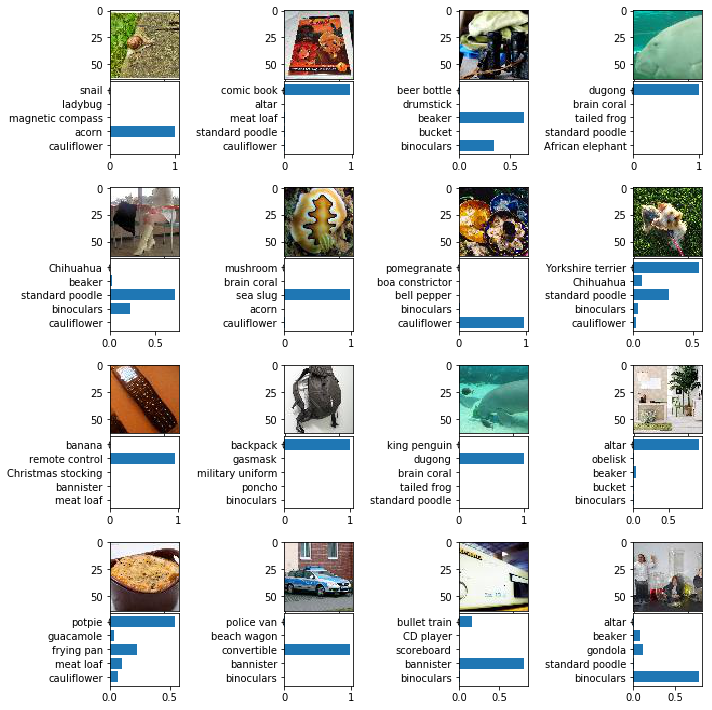

In [84]:
# Predict batch by batch:
predictions = resnet_model.predict(test_input_fn, yield_single_examples=False)

batch_id = 0
for predictions_dict in predictions: # Iterating the predictions generator:
    batch_images = test_images[batch_id * batch_size: (batch_id + 1) * batch_size]
    
    top5_labels, top5_probabilities = process_predictions(
        predictions_dict, TINY_IMAGENET_CLASS_IDS, TINY_IMAGENET_READABLE_LABELS)
    
    display_predictions(batch_images, top5_labels, top5_probabilities)
    
    batch_id += 1
    
    # stopping the loop early to display just one batch for this example:
    if batch_id > 0:
        break
    

To summarize, we just learned how to use together TensorFlow Estimators and TensorFlow Hub to build powerful models reusing architectures and trained weights shared by the community. We saw how these models can be configured, trained, and used in production.